# INN

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm

import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=False)  # Changed inplace to False
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        out = F.relu(out, inplace=False)   # Use non-in-place ReLU
        return out

class ResNet3(nn.Module):
    def __init__(self, block, layers, num_classes = 2):
        super(ResNet3, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(5, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [3]:
model2 = ResNet3(ResidualBlock, [3, 4, 6, 3], num_classes = 10).to("cpu")
model2.load_state_dict(torch.load("best_resnet50_MINST-DVS_with_maxpool_same.pt", weights_only=True))
model2.to("cpu")
model2.eval()


c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


ResNet3(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, mo

## Na ISNN

### Dense

In [4]:
def call_spiking(tj, W, D_i, t_min, t_max, noise, dtype=torch.FloatTensor):
    """
    Calculates spiking times to recover ReLU-like functionality.
    Assumes tau_c=1 and B_i^(n)=1.
    """
    # Calculate the spiking threshold (Eq. 18)
    threshold = t_max - t_min - D_i
    
    # Calculate output spiking time ti (Eq. 7)

    ti = torch.matmul((tj - t_min).type(dtype), W.type(dtype)) + threshold + t_min
    
    # Ensure valid spiking time: do not spike for ti >= t_max
    ti = torch.where(ti < t_max, ti, t_max)

    # Add noise to the spiking time for noise simulations
    if noise > 0:
        ti = ti + torch.randn_like(ti) * noise
    
    return ti

In [5]:
class SpikingDense(nn.Module):
    def __init__(self, units, name, X_n=1, outputLayer=False, robustness_params={}, input_dim=None,
                 kernel_regularizer=None, kernel_initializer=None):
        super().__init__()
        self.units = units
        self.B_n = (1 + 0.0) * X_n
        self.outputLayer=outputLayer
        self.t_min_prev, self.t_min, self.t_max=0, 0, 1
        self.noise=robustness_params['noise']
        self.time_bits=robustness_params['time_bits']
        self.weight_bits =robustness_params['weight_bits'] 
        self.w_min, self.w_max=-1.0, 1.0
        self.alpha = torch.full((units,), 1, dtype=torch.float64)
        self.input_dim=input_dim
        self.regularizer = kernel_regularizer
        self.initializer = kernel_initializer
        self.bias = False
    
    def build(self, input_dim, kernel : torch.Tensor = None, bias : torch.Tensor = None):
        # Ensure input_dim is defined properly if not passed.
        if input_dim[-1] is None:
            input_dim = (None, self.input_dim)
        else:
            self.input_dim = input_dim
        # Create kernel weights and D_i.
        if kernel is not None:
            if bias is None:
                self.kernel = nn.Parameter(kernel.clone())
            else:
                self.kernel = nn.Parameter(torch.concat((kernel.clone(),bias.clone().unsqueeze(0))))
                self.bias = True
        else:
            self.kernel = nn.Parameter(torch.empty(input_dim[-1], self.units))
        self.D_i = nn.Parameter(torch.zeros(self.units))

        # Apply the initializer if provided.
        if self.initializer:
            self.kernel = self.initializer(self.kernel) # tu zmiana TODO

    def set_params(self, t_min_prev, t_min, in_ranges_max):
        """
        Set t_min_prev, t_min, t_max parameters of this layer. Alpha is fixed at 1.
        """
        
        if self.bias:
            max_W = torch.concat((torch.maximum(self.kernel[:-1],torch.zeros(self.kernel[:-1].shape)), self.kernel[-1].unsqueeze(0)))
            max_input = torch.concat((torch.tensor(in_ranges_max), torch.tensor([(1)])))
        else:
            max_input = torch.tensor(in_ranges_max)
            max_W = torch.maximum(self.kernel,torch.zeros(self.kernel.shape))
        output_val = F.relu(torch.matmul(max_input,max_W))
        max_V = F.relu(torch.max(torch.matmul(max_input,max_W)))

        self.t_min_prev = torch.tensor(t_min_prev, dtype=torch.float64, requires_grad=False)
        self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
        self.t_max = torch.tensor(t_min + self.B_n*max_V, dtype=torch.float64, requires_grad=False)

        
        # Returning for function signature consistency
        return t_min, t_min + self.B_n*max_V, output_val
    
    def forward(self, tj):
        """
        Input spiking times `tj`, output spiking times `ti` or membrane potential value for the output layer.
        """
        # Call the custom spiking logic
        if self.bias:
            print(tj.shape)
            new_tj = torch.concat((tj, torch.tensor([[(self.t_min - 1)]])), dim=1)
            output = call_spiking(new_tj, self.kernel, self.D_i, self.t_min, self.t_max, noise=self.noise)
        else:
            output = call_spiking(tj, self.kernel, self.D_i, self.t_min, self.t_max, noise=self.noise)
        # If this is the output layer, perform the special integration logic
        if self.outputLayer:
            # Compute weighted product
            W_mult_x = torch.matmul(self.t_min - tj, self.kernel)
            self.alpha = self.D_i / (self.t_min - self.t_min_prev)
            output = self.alpha * (self.t_min - self.t_min_prev) + W_mult_x

        return output

### Conv2D

In [6]:
class SpikingConv2D(nn.Module):
    def __init__(self, filters, name, X_n=1, padding='same', kernel_size=(3,3), robustness_params=None, kernels = None, device = 'cuda:0', biases = None, stride=1):
        super(SpikingConv2D, self).__init__()
        self.stride = stride
        if robustness_params is None:
            robustness_params = {}
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.B_n = (1 + 0.0) * X_n
        self.t_min_prev, self.t_min, self.t_max = 0, 0, 1
        self.w_min, self.w_max = -1.0, 1.0
        self.time_bits = robustness_params.get('time_bits', 1)
        self.weight_bits = robustness_params.get('weight_bits', 1) 
        self.noise = robustness_params.get('noise', 0.0)
        self.device = device
        # Initialize alpha as a tensor of ones
        self.alpha = nn.Parameter(torch.ones(filters, dtype=torch.float32))
        
        # Registering the kernel as a learnable parameter
        #TODO:
        if kernels is not None:
            self.kernel = nn.Parameter(kernels).to(device)
        else:
            self.kernel = nn.Parameter(torch.randn(filters, 1, kernel_size[0], kernel_size[1], dtype=torch.float32)).to(device)
        if biases is not None:
            self.B = biases.unsqueeze(1).to(self.device)
        else:
            self.B = nn.Parameter(torch.zeros(filters, 1, dtype=torch.float32)).to(self.device)

        # Placeholder for batch normalization parameters
        self.BN = nn.Parameter(torch.tensor([0], dtype=torch.float32), requires_grad=False)
        self.BN_before_ReLU = nn.Parameter(torch.tensor([0], dtype=torch.float32), requires_grad=False)
        
        # Parameter for different thresholds
        self.D_i = nn.Parameter(torch.zeros(9, filters, dtype=torch.float32)).to(self.device)

    def set_params(self, t_min_prev, t_min, in_ranges_max, minimal_t_max = 0):
        """
        Set t_min_prev, t_min, t_max, J_ij (kernel) and vartheta_i (threshold) parameters of this layer.
        """
        max_W = torch.maximum(self.kernel,torch.zeros(self.kernel.shape).to(self.device))
        print(max_W.shape)
        
        max_input = (in_ranges_max.unsqueeze(-1).unsqueeze(-1)).to(self.device) * torch.ones(self.kernel.shape[1:]).to(self.device)

        print(max_input.shape)
        if self.B is not None:
            max_V = F.relu(torch.max(torch.sum(torch.mul(max_input,max_W),(1,2,3))+self.B.squeeze(1)))
            max_values = F.relu(torch.sum(torch.mul(max_input,max_W),(1,2,3))+self.B.squeeze(1))
        else:
            max_V = F.relu(torch.max(torch.sum(torch.mul(max_input,max_W),(1,2,3))))
            max_values = F.relu(torch.sum(torch.mul(max_input,max_W),(1,2,3)))
        self.t_min_prev = torch.tensor(t_min_prev, dtype=torch.float64, requires_grad=False)
        self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
        self.t_max = torch.tensor(max(t_min + self.B_n*max_V, minimal_t_max), dtype=torch.float64, requires_grad=False)
        
        # Returning for function signature consistency
        return t_min, max(t_min + self.B_n*max_V, minimal_t_max), max_values

    def call_spiking(self, tj, W, D_i, t_min, t_max, noise):
        """
        Calculates spiking times from which ReLU functionality can be recovered.
        """
        threshold = t_max - t_min - D_i
        
        # Calculate output spiking time ti
        ti = torch.matmul(tj - t_min, W) + threshold + t_min
        
        # Ensure valid spiking time
        ti = torch.where(ti < t_max, ti, t_max)
        
        # Add noise
        if noise > 0:
            ti += torch.randn_like(ti) * noise
        
        return ti

    def forward(self, tj):
        """
        Input spiking times tj, output spiking times ti. 
        """
        if self.stride==1:
            padding_size = int(self.padding == 'same') * ((self.kernel_size[0]-1) // 2)
        else:
            # dont know if it works with stride other than 1 always set padding to valid
            padding_size = int(self.padding == 'same') * ((self.kernel_size[0]-1) // 2)
        image_same_size = tj.size(2) 
        image_valid_size = image_same_size - self.kernel_size[0] + 1


        tj_shape = tj.shape
        # Dodanie paddingu
        if self.padding == 'same':
            tj = torch.nn.functional.pad(tj, (padding_size, padding_size, padding_size, padding_size), value=self.t_min)
        elif type(self.padding) is tuple:
            tj = torch.nn.functional.pad(tj, (self.padding[0], self.padding[0], self.padding[1], self.padding[1]), value=self.t_min)
            pass
        # Wyciąganie patchy
        if self.stride==1:
            batch_size, in_channels, input_height, input_width = tj.shape
            tj = torch.nn.functional.unfold(tj, kernel_size=self.kernel_size, stride=1).transpose(1, 2)
            # Reshape dla wag
            W = self.kernel.view(self.filters, -1).t()
            out_channels, _, kernel_height, kernel_width = self.kernel.shape
            output_height = (input_height - kernel_height) // self.stride + 1
            output_width = (input_width - kernel_width) // self.stride + 1
        else:
            batch_size, in_channels, input_height, input_width = tj.shape
            tj = torch.nn.functional.unfold(tj, kernel_size=self.kernel_size, stride=self.stride).transpose(1, 2)
            out_channels, _, kernel_height, kernel_width = self.kernel.shape
            output_height = (input_height - kernel_height) // self.stride + 1
            output_width = (input_width - kernel_width) // self.stride + 1
            # Reshape dla wag
            W = self.kernel.view(out_channels, -1).t()
        
        
        
        if (self.padding == 'valid' or self.BN != 1 or self.BN_before_ReLU == 1) and (self.B is None): 

            ti = self.call_spiking(tj, W, self.D_i[0], self.t_min, self.t_max, noise=self.noise).transpose(1, 2)
            if self.padding == 'valid':
                ti = ti.view(batch_size, out_channels, output_height, output_width)
            else:
                ti = ti.view(batch_size, out_channels, output_height, output_width)

        elif self.B is not None:
            ## concatenating simple "one" to vector of times
            one_as_time = self.t_min - 1
            tj = torch.concat((tj, one_as_time * torch.ones(tj.shape[0],tj.shape[1],1).to(self.device)), 2)
            ## conttenating biases to weight vector
            W = torch.concat((W,self.B.T),0)
            ti = self.call_spiking(tj, W, self.D_i[0], self.t_min, self.t_max, noise=self.noise).transpose(1, 2)
            if self.padding == 'valid':
                ti = ti.view(batch_size, out_channels, output_height, output_width)
            else:
                ti = ti.view(batch_size, out_channels, output_height, output_width)

        return ti

In [7]:
def fuse_conv_and_bn(conv, bn, device = 'cuda:0'):
	#
	# init
	fusedconv = torch.nn.Conv2d(
		conv.in_channels,
		conv.out_channels,
		kernel_size=conv.kernel_size,
		stride=conv.stride,
		padding=conv.padding,
		bias=True
	)
	#
	# prepare filters
	w_conv = conv.weight.clone().view(conv.out_channels, -1)
	w_bn = torch.diag(bn.weight.div(torch.sqrt(bn.eps+bn.running_var)))
	with torch.no_grad():
		fusedconv.weight.copy_( torch.mm(w_bn, w_conv).view(fusedconv.weight.size()) )
	#
	# prepare spatial bias
	if conv.bias is not None:
		b_conv = conv.bias
	else:
		b_conv = torch.zeros( conv.weight.size(0) ).to(device)
	b_bn = bn.bias - bn.weight.mul(bn.running_mean).div(torch.sqrt(bn.running_var + bn.eps))
	with torch.no_grad():
		fusedconv.bias.copy_( (torch.matmul(w_bn, b_conv) + b_bn) )
	
	return fusedconv.to(device)

### Maxpool

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaxMinPool2D(nn.Module):
    """
    Max Pooling or Min Pooling operation, depending on the sign of the batch normalization layer before.
    """
    def __init__(self, kernel_size, max_time, stride=None, padding=0, dilation=1):
        super(MaxMinPool2D, self).__init__()
        
        # Default sign is 1, indicating max pooling functionality.
        self.sign = nn.Parameter(-1*torch.ones(1, 1, 1, 1), requires_grad=False)
        self.dilation = dilation
        # MaxPool2d setup (will be used in call)
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.max_time = max_time

    def forward(self, inputs):
        # Applying the sign to the inputs (if sign is -1, it will act as Min Pooling)
        padding_size = self.padding
        inputs = torch.nn.functional.pad(inputs, (padding_size, padding_size, padding_size, padding_size), value=self.max_time)
        pooled = F.max_pool2d(self.sign * inputs, kernel_size=self.kernel_size, stride=self.stride, padding=0, dilation=self.dilation)
        
        # Multiply the pooled result by the sign, which controls the pooling type
        return pooled * self.sign

### Add Layer

In [9]:
class AddSNNLayer(nn.Module):
    def __init__(self):
        super(AddSNNLayer, self).__init__()
        self.noise = 0
        self.B_n = 1
        pass

    def set_params(self, t_min_prev, t_min, input1_val, input2_val, minimal_t_max = 0):
        output_val = input1_val + input2_val
        max_V = max(output_val)
        self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
        self.t_max = torch.tensor(max(t_min + self.B_n*max_V, minimal_t_max), dtype=torch.float64, requires_grad=False)
        return t_min, max(t_min + self.B_n*max_V, minimal_t_max), output_val

    def forward(self, tj1, tj2):
        D_i = 0
        threshold = self.t_max - self.t_min - D_i
        
        ti = tj1 + tj2 - 2*self.t_min  + threshold + self.t_min

        ti = torch.where(ti < self.t_max, ti, self.t_max)

        if self.noise > 0:
            ti += torch.randn_like(ti) * self.noise
        
        return ti

### Identity

In [10]:
class IdentitySNNLayer(nn.Module):
    def __init__(self):
        super(IdentitySNNLayer, self).__init__()
        self.noise = 0
        self.B_n = 1
        pass

    def set_params(self, t_min_prev, t_min, in_ranges_max, minimal_t_max = 0):

        max_input = max(in_ranges_max)
        max_V = max_input
        self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
        self.t_max = torch.tensor(max(t_min + self.B_n*max_V, minimal_t_max), dtype=torch.float64, requires_grad=False)
        return t_min, max(t_min + self.B_n*max_V, minimal_t_max), in_ranges_max

    def forward(self, tj):
        D_i = 0
        threshold = self.t_max - self.t_min - D_i
        
        ti = tj - self.t_min  + threshold + self.t_min

        ti = torch.where(ti < self.t_max, ti, self.t_max)

        if self.noise > 0:
            ti += torch.randn_like(ti) * self.noise
        
        return ti

### ResidualBlockSNN

In [11]:
class ResidualSNNBlock(nn.Module):
    def __init__(self,resblock : ResidualBlock, in_channels, out_channels, stride=1, downsample=None, robustness_params = None, device = "cuda:0"):
        super(ResidualSNNBlock, self).__init__()
        conv = resblock.conv1[0]
        bn= resblock.conv1[1]
        bn.eval()
        conv_fused = fuse_conv_and_bn(conv, bn)
        self.conv1 = SpikingConv2D(out_channels, "temp1", device=device, padding=(1,1), stride=stride, kernel_size=(3,3),robustness_params=robustness_params, kernels=conv_fused.weight.data, biases= conv_fused.bias.data)
        self.device = device
        
        conv = resblock.conv2[0]
        bn= resblock.conv2[1]
        bn.eval()
        conv_fused = fuse_conv_and_bn(conv, bn)
        self.conv2 = SpikingConv2D(out_channels, "temp1", device=device, padding=(1,1), stride=stride, kernel_size=(3,3),robustness_params=robustness_params, kernels=conv_fused.weight.data, biases= conv_fused.bias.data)

        self.downsample = downsample
        self.identity = IdentitySNNLayer()
        self.add_layer = AddSNNLayer()
        self.out_channels = out_channels

    def set_params(self, t_min_prev, t_min, input_val, minimal_t_max = 0):
        """
        Set t_min_prev, t_min, t_max, J_ij (kernel) and vartheta_i (threshold) parameters of this layer.
        """
        t_min1, t_max1, conv1_val = self.conv1.set_params(t_min_prev=t_min_prev,t_min=t_min, in_ranges_max=input_val)
        self.pooling1 = MaxMinPool2D(2, t_max1.data,2).to(self.device)
        t_min2, t_max2, conv2_val = self.conv2.set_params(t_min_prev=t_min1,t_min=t_max1, in_ranges_max=conv1_val)
        max_out2 = t_max2 - t_min2
        
        if self.downsample:
            t_min_dummy, t_max1_dummy, downsample_val = self.downsample.set_params(t_min_prev=t_min_prev,t_min=t_min, in_ranges_max=input_val)
            max_dummy1 = t_max1_dummy - t_min_dummy
            t_min_dummy, t_max1_dummy, downsample_val = self.downsample.set_params(t_min_prev=t_min_prev,t_min=t_min,minimal_t_max=t_max2, in_ranges_max=input_val)
            self.pooling2 = MaxMinPool2D(2, t_max1_dummy.data,2).to(self.device)
        else:
            t_min_dummy, t_max1_dummy, downsample_val = self.identity.set_params(t_min_prev=t_min_prev,t_min=t_min, in_ranges_max=input_val)
            max_dummy1 = t_max1_dummy - t_min_dummy
            t_min_dummy, t_max1_dummy, downsample_val = self.identity.set_params(t_min_prev=t_min_prev,t_min=t_min,minimal_t_max=t_max2, in_ranges_max=input_val)

        t_min2, t_max2, conv2_val = self.conv2.set_params(t_min_prev=t_min1,t_min=t_max1, minimal_t_max=t_max1_dummy, in_ranges_max=conv1_val)
        
        # time t_max2 and t_max1_dummy are the same
        t_min_add = t_max2 - max(max_dummy1, max_out2)

        self.t_min, self.t_max, add_val = self.add_layer.set_params(t_min_add, t_max2, conv2_val, downsample_val)

        self.times = [(t_min1, t_max1, 'c'), (t_min2, t_max2, 'c'), (self.t_min, self.t_max, 'a') ]
        return self.t_min, self.t_max, add_val

    def get_main_times(self):
        return self.times

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        if self.downsample:
            residual = self.downsample(x)
            residual = self.pooling2(residual)
            out = self.pooling1(out)
        else:
            residual = self.identity(x)
        out = self.conv2(out)
        out = self.add_layer(out,residual)
        return out

### Layer

In [12]:
class LayerSNN(nn.Module):
    def __init__(self, layer, inplanes, planes, blocks, stride=1, device = 'cuda:0'):
        self.inplanes = inplanes

        downsample = None
        if stride != 1 or self.inplanes != planes:
            conv2d, bias_from_nn = layer[0].downsample[0], layer[0].downsample[1]
            conv_fused = fuse_conv_and_bn(conv2d, bias_from_nn)
            robustness_params={
                'noise':0.0,
                'time_bits':0,
                'weight_bits': 0,
                'latency_quantiles':0.0
            }
            downsample = SpikingConv2D(planes,"test2", padding='same', stride=1, device=device,robustness_params=robustness_params,kernels=conv_fused.weight.data, biases=conv_fused.bias, kernel_size=(1,1))
            # t_min, t_max = spiking_conv2.set_params(0,1)stride
            
        self.layers = []
        self.layers.append(ResidualSNNBlock(layer[0],self.inplanes,planes, 1, downsample=downsample, device=device))
        self.inplanes = planes
        self.blocks = blocks
        for i in range(1, blocks):
            self.layers.append(ResidualSNNBlock(layer[i],self.inplanes,planes, 1, downsample=None, device=device))
        
    
    def set_params(self, t_min_prev, t_min, in_ranges_max, minimal_t_max = 0):
        tmin, tmax = t_min_prev, t_min
        for i in range(self.blocks):
            tmin, tmax, in_ranges_max = self.layers[i].set_params(tmin, tmax,in_ranges_max)
        return tmin, tmax, in_ranges_max
    
    def get_main_times(self):
        lst = []
        for i in range(self.blocks):
            lst.extend(self.layers[i].get_main_times())
        return lst
    
    def forward(self, x):
        for i in range(self.blocks):
            x = self.layers[i].forward(x)
        return x

In [13]:
random_input = torch.rand(1, 5, 224, 224)

In [14]:
model_conv1 = model2.conv1(random_input)
model_maxpool = model2.maxpool(model_conv1)
model_layer0 = model2.layer0(model_maxpool)
model_layer1 = model2.layer1(model_layer0)
model_layer2 = model2.layer2(model_layer1)
model_layer3 = model2.layer3(model_layer2)
model_maxpool2 = model2.avgpool(model_layer3)
# model2.fc.bias = nn.Parameter(torch.ones(10)*1000)
model_linear = F.relu(model2.fc(model_maxpool2.view(model_layer3.size(0), -1)))

## Conv

In [15]:
robustness_params={
    'noise':0.0,
    'time_bits':0,
    'weight_bits': 0,
    'latency_quantiles':0.0
}

In [16]:
conv_fused = fuse_conv_and_bn(model2.conv1[0], model2.conv1[1])
conv_first = SpikingConv2D(64, "temp1", device = 'cpu', padding=(3,3), stride=2, kernel_size=(7,7),robustness_params=robustness_params, kernels=conv_fused.weight.data, biases= conv_fused.bias.data)
max_vect = torch.tensor([1,1,1,1,1])
tmin, tmax, max_vect = conv_first.set_params(0,1,max_vect)
print(tmin, tmax)


torch.Size([64, 5, 7, 7])
torch.Size([5, 7, 7])
1 tensor(4.1255, grad_fn=<AddBackward0>)


C:\Users\nikos\AppData\Local\Temp\ipykernel_10232\842815000.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(max(t_min + self.B_n*max_V, minimal_t_max), dtype=torch.float64, requires_grad=False)


In [17]:
model_conv1 = model2.conv1(random_input)
print(model_conv1.shape)

torch.Size([1, 64, 112, 112])


In [18]:
print(max_vect)

tensor([1.6246e-02, 0.0000e+00, 1.4638e-05, 2.4723e+00, 1.1368e-02, 2.3802e-02,
        0.0000e+00, 0.0000e+00, 2.0605e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.1276e-01, 5.6592e-06, 5.3766e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.6908e-03, 1.2543e-02, 0.0000e+00, 0.0000e+00, 1.1855e-02, 1.2451e-02,
        0.0000e+00, 4.6424e-02, 1.3234e-05, 0.0000e+00, 0.0000e+00, 6.0138e-03,
        8.2080e-02, 2.4156e+00, 0.0000e+00, 2.4081e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.4718e-01, 1.5143e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6739e-01, 0.0000e+00, 8.4220e-03,
        9.5504e-03, 2.4821e-02, 0.0000e+00, 0.0000e+00, 1.1658e-02, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.1255e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2010e-01],
       grad_fn=<ReluBackward0>)


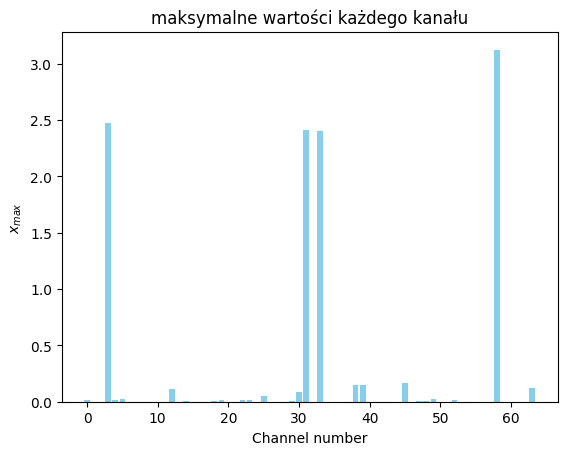

In [19]:
# Tworzenie przykładowego array'a
values = max_vect.detach().numpy()
labels = [ i for i in range(len(max_vect))]

# Tworzenie wykresu słupkowego
plt.bar(labels, values, color='skyblue')

# Dodanie etykiet
plt.ylabel('$x_{max}$')
plt.xlabel('Channel number')
plt.title('maksymalne wartości każdego kanału')

# Wyświetlenie wykresu
plt.show()


In [20]:
SNN_input = 1 - random_input
model2.conv1.eval() ## Important eval for batch normalization
out1 = conv_first(SNN_input.to("cpu"))
out1_x = model2.conv1(random_input)
print(((conv_first.t_max - out1) - out1_x).abs().max())
print(out1.shape)

tensor(7.1526e-07, grad_fn=<MaxBackward1>)
torch.Size([1, 64, 112, 112])


In [21]:
pool = MaxMinPool2D(3, tmax.data,2,1).to("cpu")

out2 = pool(out1)

print(((tmax - out2) - model_maxpool).abs().max())

tensor(7.1526e-07, grad_fn=<MaxBackward1>)


In [22]:
# dummy = None

# resblockSNN = ResidualSNNBlock(model2.layer0[0],64,64, downsample=dummy, device='cpu')
# tmin, tmax, max_vect = resblockSNN.set_params(0,1, max_vect)
# print(tmin,tmax)


In [23]:
layer0SNN = LayerSNN(model2.layer0, 64, 64, 3,device = 'cpu')
tmin, tmax, max_vect = layer0SNN.set_params(tmin, tmax, max_vect)
print(tmin, tmax)

torch.Size([64, 64, 3, 3])
torch.Size([64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 3, 3])
tensor(37.7244, grad_fn=<AddBackward0>) tensor(44.1076, grad_fn=<AddBackward0>)


C:\Users\nikos\AppData\Local\Temp\ipykernel_10232\842815000.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_10232\842815000.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(max(t_min + self.B_n*max_V, minimal_t_max), dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_10232\842815000.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min_prev = 

In [24]:
out_3 = layer0SNN.forward(out2)

print((tmax - out_3 - model_layer0).abs().max())

tensor(9.5963e-06, grad_fn=<MaxBackward1>)


In [25]:
layer1SNN = LayerSNN(model2.layer1, 64, 128, 4,device = 'cpu')
tmin, tmax, max_vect = layer1SNN.set_params(tmin, tmax, max_vect)
print(tmin, tmax)

torch.Size([128, 64, 3, 3])
torch.Size([64, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 3, 3])
torch.Size([128, 64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([128, 64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([128, 128, 3, 3])
torch.Size([128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 3, 3])
tensor(108.5382, grad_fn=<AddBackward0>) tensor(117.7137, grad_fn=<AddBackward0>)


C:\Users\nikos\AppData\Local\Temp\ipykernel_10232\842815000.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min_prev = torch.tensor(t_min_prev, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_10232\842815000.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_10232\842815000.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(max(t_min + self.B_

In [26]:
out_4 = layer1SNN.forward(out_3)

print((tmax - out_4 - model_layer1).abs().max())

tensor(3.1219e-05, grad_fn=<MaxBackward1>)


In [27]:
layer2SNN = LayerSNN(model2.layer2, 128, 256, 6,device = 'cpu')
tmin, tmax, max_vect = layer2SNN.set_params(tmin, tmax, max_vect)
print(tmin, tmax)

torch.Size([256, 128, 3, 3])
torch.Size([128, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 128, 1, 1])
torch.Size([128, 1, 1])
torch.Size([256, 128, 1, 1])
torch.Size([128, 1, 1])
torch.Size([256, 256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 3, 3])


C:\Users\nikos\AppData\Local\Temp\ipykernel_10232\842815000.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min_prev = torch.tensor(t_min_prev, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_10232\842815000.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_10232\842815000.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(max(t_min + self.B_

torch.Size([256, 256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 3, 3])
tensor(2472.7686, grad_fn=<AddBackward0>) tensor(2720.7036, grad_fn=<AddBackward0>)


In [28]:
out_5 = layer2SNN.forward(out_4)

print((tmax - out_5 - model_layer2).abs().max())

tensor(0.0007, grad_fn=<MaxBackward1>)


In [29]:
layer3SNN = LayerSNN(model2.layer3, 256, 512, 3,device = 'cpu')
tmin, tmax, max_vect = layer3SNN.set_params(tmin, tmax, max_vect)
print(tmin, tmax)

torch.Size([512, 256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 3, 3])
torch.Size([512, 256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([512, 256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([512, 512, 3, 3])
torch.Size([512, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 3, 3])
tensor(89230.4062, grad_fn=<AddBackward0>) tensor(122485.5391, grad_fn=<AddBackward0>)


C:\Users\nikos\AppData\Local\Temp\ipykernel_10232\842815000.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min_prev = torch.tensor(t_min_prev, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_10232\842815000.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_10232\842815000.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(max(t_min + self.B_

In [30]:
out_6 = layer3SNN.forward(out_5)

print((tmax - out_6 - model_layer3).abs().max())

tensor(0.0165, grad_fn=<MaxBackward1>)


In [31]:
pool2 = MaxMinPool2D(7, tmax.data,1,0).to("cpu")

out7 = pool2(out_6)

print(((tmax - out7) - model_maxpool2).abs().max())

tensor(0.0149, grad_fn=<MaxBackward1>)


In [32]:
spiking_dense = SpikingDense(10,"test",robustness_params=robustness_params)
weights = model2.fc.weight.T
biases = model2.fc.bias
spiking_dense.build((512,),weights, biases)
tmin, tmax, max_vect = spiking_dense.set_params(tmin, tmax, max_vect)
print(tmin, tmax)

tensor(122485.5391, grad_fn=<AddBackward0>) tensor(175559.0625, grad_fn=<AddBackward0>)


C:\Users\nikos\AppData\Local\Temp\ipykernel_10232\2453877980.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_input = torch.concat((torch.tensor(in_ranges_max), torch.tensor([(1)])))
C:\Users\nikos\AppData\Local\Temp\ipykernel_10232\2453877980.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min_prev = torch.tensor(t_min_prev, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_10232\2453877980.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min = torch.tensor(t_min, dtype=t

In [33]:
out8 = spiking_dense(out7.view(out7.size(0), -1))

print((tmax - out8 - model_linear).abs().max())

torch.Size([1, 512])
tensor(0.0114, grad_fn=<MaxBackward1>)


In [34]:
layer_lst = [layer0SNN, layer1SNN, layer2SNN, layer3SNN]
ll = []
for i in layer_lst:
    ll.extend(i.get_main_times())

In [35]:
print(ll)

[(tensor(4.1255, grad_fn=<AddBackward0>), tensor(5.9594, grad_fn=<AddBackward0>), 'c'), (tensor(5.9594, grad_fn=<AddBackward0>), tensor(12.3124, grad_fn=<AddBackward0>), 'c'), (tensor(12.3124, grad_fn=<AddBackward0>), tensor(18.6654, grad_fn=<AddBackward0>), 'a'), (tensor(18.6654, grad_fn=<AddBackward0>), tensor(19.6259, grad_fn=<AddBackward0>), 'c'), (tensor(19.6259, grad_fn=<AddBackward0>), tensor(25.0184, grad_fn=<AddBackward0>), 'c'), (tensor(25.0184, grad_fn=<AddBackward0>), tensor(31.3714, grad_fn=<AddBackward0>), 'a'), (tensor(31.3714, grad_fn=<AddBackward0>), tensor(31.7759, grad_fn=<AddBackward0>), 'c'), (tensor(31.7759, grad_fn=<AddBackward0>), tensor(37.7244, grad_fn=<AddBackward0>), 'c'), (tensor(37.7244, grad_fn=<AddBackward0>), tensor(44.1076, grad_fn=<AddBackward0>), 'a'), (tensor(44.1076, grad_fn=<AddBackward0>), tensor(46.0149, grad_fn=<AddBackward0>), 'c'), (tensor(46.0149, grad_fn=<AddBackward0>), tensor(54.1335, grad_fn=<AddBackward0>), 'c'), (tensor(54.1335, grad_f

In [36]:
tt = [i[1].detach().numpy() for i in ll]

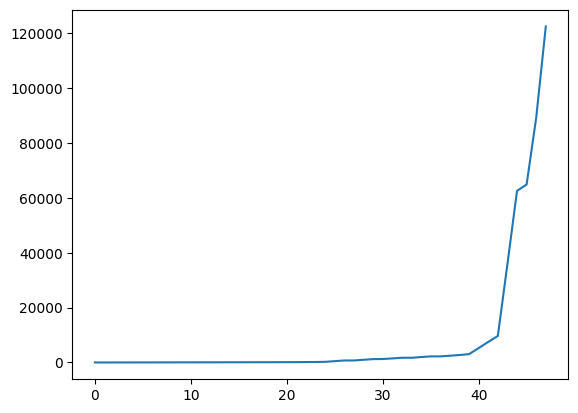

In [37]:
import matplotlib.pyplot as plt

plt.plot(tt)
# plt.ylim([0,2000])

In [38]:
tt2 = [(tt[i])/(tt[i-1]) for i in range(2,len(tt))]

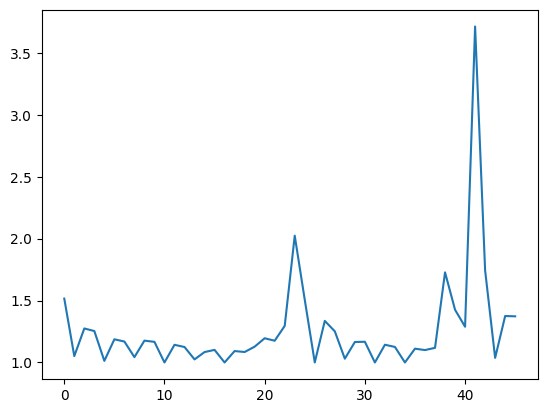

In [39]:
import matplotlib.pyplot as plt

plt.plot(tt2)